In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Load data and separate train from test-phase

There are cases where load and temp data are missing due to a blackout (see Known_Artifacts.md for an inexhaustive list)

We need to impute the temperature data to use it for training ARIMA-type models. We did NOT need this for the univariate model since complete data is only assumed for covariate (not the outcome).

In [3]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [4]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index >= '2021-07-01']
target_data = target_data.asfreq('H')

# First Pass

## AR(1) Model

Since we're going to have temperature data included, we can likely reduce the number of parameters (reduce overfitting) and stop using the moving average and integration components

In [ ]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 0, 0), trend='t')

# Estimate the parameters
res = mod.fit()

print(res.summary())

### Get Results Through 10/31/21

In [ ]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

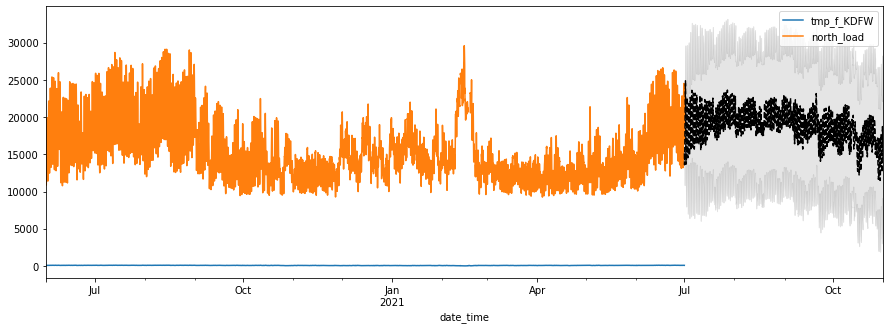

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2020-06-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## AR(12) Model

Since we're going to have temperature data included, we can likely reduce the number of parameters (reduce overfitting) and stop using the moving average and integration components

In [5]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(12, 0, 0), trend='c')

# Estimate the parameters
res = mod.fit()

print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33769D+00    |proj g|=  5.22302D-02

At iterate    5    f=  7.33401D+00    |proj g|=  1.71522D-03

At iterate   10    f=  7.33086D+00    |proj g|=  3.15604D-02

At iterate   15    f=  7.14927D+00    |proj g|=  1.37185D-01

At iterate   20    f=  7.10799D+00    |proj g|=  5.11798D-02

At iterate   25    f=  7.09204D+00    |proj g|=  1.37215D-02

At iterate   30    f=  7.09137D+00    |proj g|=  1.84211D-03

At iterate   35    f=  7.09129D+00    |proj g|=  4.38694D-03

At iterate   40    f=  7.08942D+00    |proj g|=  3.69421D-02

At iterate   45    f=  7.08351D+00    |proj g|=  1.54268D-02

At iterate   50    f=  7.07674D+00    |proj g|=  2.12629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(12, 0, 0)   Log Likelihood             -278880.284
Date:                Fri, 17 Jun 2022   AIC                         557790.568
Time:                        11:33:25   BIC                         557919.293
Sample:                    01-01-2017   HQIC                        557831.341
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.8105      8.211      0.708      0.479     -10.282      21.903
tmp_f_KDFW   -35.4577      1.189    -29.824      0.000     -37.788     -33.127
ar.L1          2.1997      0.005    410.059      0.0

### Get Results Through 10/31/21

In [6]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  14807.609142    366.508583   14204.756169   
2021-07-01 01:00:00-06:00  13628.536347    885.600939   12171.852431   
2021-07-01 02:00:00-06:00  12911.254388   1434.511286   10551.693297   
2021-07-01 03:00:00-06:00  12598.003975   1981.622958    9338.524265   
2021-07-01 04:00:00-06:00  12657.895797   2519.498437    8513.689656   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  22652.280547  26845.544963  -21504.711453   
2021-10-31 20:00:00-06:00  22745.096352  26846.154858  -21412.898835   
2021-10-31 21:00:00-06:00  22848.549129  26846.764078  -21310.448137   
2021-10-31 22:00:00-06:00  22962.638878  26847.372625  -21197.359359   
2021-10-31 23:00:00-06:00  23023.541736  26847.980499  -21137.456364   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15410.462114  
2021-07-01 01:00:00-06:00   15085.220263  
2021-0

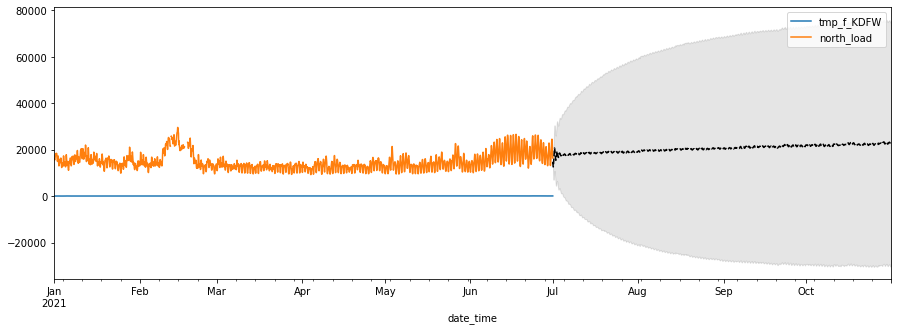

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## AR(24) Model

In [8]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 0, 0), trend='c')

# Estimate the parameters
res = mod.fit()

print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16294D+00    |proj g|=  6.70385D-02

At iterate    5    f=  7.15954D+00    |proj g|=  1.49259D-02

At iterate   10    f=  7.15936D+00    |proj g|=  2.72227D-03

At iterate   15    f=  7.15916D+00    |proj g|=  3.26829D-03

At iterate   20    f=  7.15905D+00    |proj g|=  2.16814D-03

At iterate   25    f=  7.15849D+00    |proj g|=  1.08748D-02

At iterate   30    f=  7.15500D+00    |proj g|=  4.74413D-02

At iterate   35    f=  7.14530D+00    |proj g|=  7.31415D-02

At iterate   40    f=  7.13158D+00    |proj g|=  3.89153D-02

At iterate   45    f=  7.11942D+00    |proj g|=  1.67643D-01

At iterate   50    f=  7.10658D+00    |proj g|=  7.33848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(24, 0, 0)   Log Likelihood             -280056.122
Date:                Fri, 17 Jun 2022   AIC                         560166.244
Time:                        11:51:37   BIC                         560397.950
Sample:                    01-01-2017   HQIC                        560239.637
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3645      2.353      1.855      0.064      -0.247       8.976
tmp_f_KDFW   190.3115      0.652    291.783      0.000     189.033     191.590
ar.L1          1.8457      0.004    454.410      0.0

### Get Results Through 10/31/21

In [9]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  15058.210270    348.094201   14485.646261   
2021-07-01 01:00:00-06:00  14097.924670    730.709651   12896.014250   
2021-07-01 02:00:00-06:00  13363.522862   1049.893716   11636.601375   
2021-07-01 03:00:00-06:00  13094.991481   1310.437804   10939.513106   
2021-07-01 04:00:00-06:00  13294.161216   1526.058152   10784.018930   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  29244.727556  25668.460737  -12976.133186   
2021-10-31 20:00:00-06:00  27832.885017  25670.318054  -14391.030740   
2021-10-31 21:00:00-06:00  26472.070373  25673.071146  -15756.373815   
2021-10-31 22:00:00-06:00  25215.120116  25676.833847  -17019.513166   
2021-10-31 23:00:00-06:00  24446.959427  25681.613010  -17795.534878   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15630.774278  
2021-07-01 01:00:00-06:00   15299.835089  
2021-0

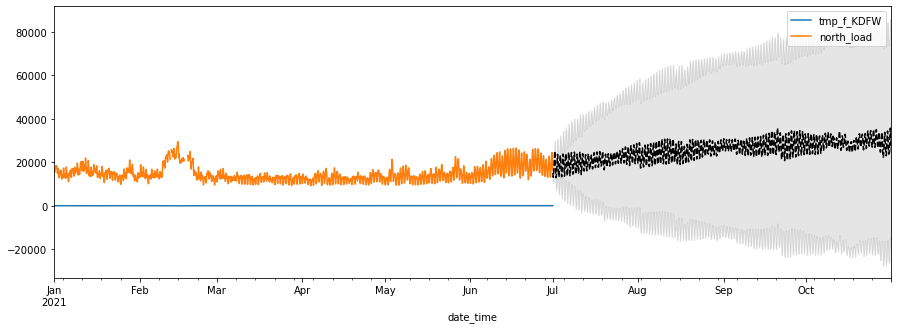

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## ARIMA(24, 1, 8) Model

In [11]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 1, 8), trend='c')

# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92353D+00    |proj g|=  2.86071D-01


 This problem is unconstrained.



At iterate    5    f=  6.86219D+00    |proj g|=  8.80763D-02

At iterate   10    f=  6.84473D+00    |proj g|=  3.13738D-02

At iterate   15    f=  6.84157D+00    |proj g|=  3.48006D-02

At iterate   20    f=  6.83892D+00    |proj g|=  1.64414D-02

At iterate   25    f=  6.83780D+00    |proj g|=  1.12994D-02

At iterate   30    f=  6.83722D+00    |proj g|=  8.25476D-03

At iterate   35    f=  6.83708D+00    |proj g|=  2.72937D-03

At iterate   40    f=  6.83688D+00    |proj g|=  1.28514D-02

At iterate   45    f=  6.83647D+00    |proj g|=  4.30399D-03


/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.83627D+00    |proj g|=  7.87154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     57      1     0     0   7.872D-03   6.836D+00
  F =   6.8362661367804707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(24, 1, 8)   Log Likelihood             -269403.576
Date:                Fri, 17 Jun 2022   AIC                         538877.152
Time:                        12:03:57   BIC  

### Get Results Through 10/31/21

In [12]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  15089.401109    260.668409   14660.639731   
2021-07-01 01:00:00-06:00  14217.561193    556.762406   13301.768529   
2021-07-01 02:00:00-06:00  13603.844625    824.790111   12247.185620   
2021-07-01 03:00:00-06:00  13409.323433   1066.077306   11655.782309   
2021-07-01 04:00:00-06:00  13736.552848   1279.478025   11631.998778   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  16862.213039  27633.332347  -28590.573896   
2021-10-31 20:00:00-06:00  16566.655717  27637.984176  -28893.782796   
2021-10-31 21:00:00-06:00  16229.405679  27642.593072  -29238.613794   
2021-10-31 22:00:00-06:00  15847.992923  27647.157870  -29627.534975   
2021-10-31 23:00:00-06:00  15652.068952  27651.680382  -29830.897816   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15518.162488  
2021-07-01 01:00:00-06:00   15133.353856  
2021-0

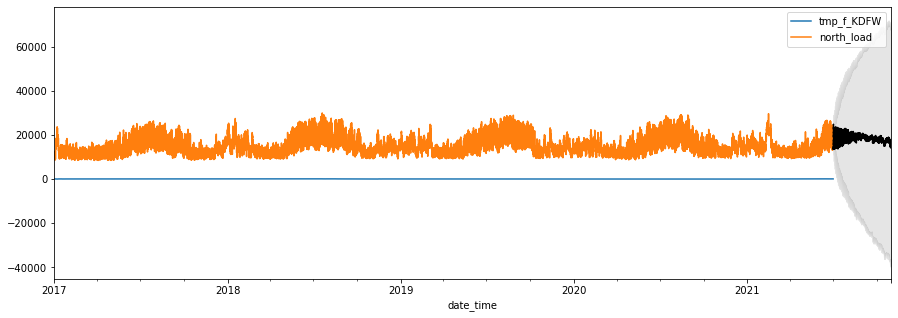

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.plot(ax=ax, legend=True)
# train_data.tmp_f_KDFW.loc['2020-01-01':].plot(ax=ax, secondary_y=True, legend=True)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## Analysis to Here

We are getting something that looks better on point estimates. We are getting good daily behavior (at least in the early forecasts) and a slightly increasing trend into late summer and then a decreasing trend as we hit fall.

This is imperfect, though. The daily trend is decaying a bit (likely because integration component is taking over from AR(24) component. Additionally, the variance is blowing up to unreasonable levels (e.g. forecasted negative load). My suspicion is that the model is not paying enough attention to the exogenous (weather) variables, which can be accounted for by standardizing each series individually.